<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/Data%20Science%20Projects/Loan%20Prediction/Loan_Prediction__Eric_pyod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Variable Name      | Description | Example Data |
|--------------------|-------------|--------------|
| Loan_ID            | Loan reference number. | LP001002; LP001003; ... |
| Gender             | Applicant's gender. | Male or Female  |
| Married            | Applicant's marital status.| Married or Unmarried|
| Dependents         | Number of dependents in the family. | 0; 1; 2; 3+ |
| Education          | Applicant's education/qualification. | Graduate or Non-graduate |
| Self_Employed      | Applicant's employment status. | Self-employed is Yes, employed or other is No |
| ApplicantIncome    | Applicant's monthly income/salary. | 5849; 4583; ... |
| CoapplicantIncome  | Co-applicant's monthly income/salary. | 1508; 2358; ... |
| LoanAmount         | Loan amount. | 128; 66; ... |
| Loan_Amount_Term   | Term of loan repayment (in days). | 360; 120; ... |
| Credit_History     | Previous credit history records (0: Poor credit history, 1: Good credit history). | 0; 1 |
| Property_Area      | Location of property ). | Rural/Semi-urban/Urban |
| Loan_Status        | Loan status (Y: Accepted, N: Not Accepted). | Y; N |

In [1]:
!pip install pyod

In [2]:
!pip install scikit-optimize

In [3]:
!pip install bayesian-optimization

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import os
import scipy

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from pyod.models.knn import KNN
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.models.lof import LOF

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback
from skopt.space import Integer, Categorical
from bayes_opt import BayesianOptimization
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('loan_data_set.csv')

In [6]:
df.head(20)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
# separate the categorical, numeric data
categorical_columns = df.select_dtypes(include=['object','category']).columns

numerical_columns = df.select_dtypes(include=['int64','float64']).columns

print(f'Categorical Columns: {list(categorical_columns)}')
print(f'Numerical Columns: {list(numerical_columns)}')

Categorical Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
Numerical Columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [9]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [10]:
df.shape

(614, 13)

# Exploring Data Analysis

### Loan_ID

In [11]:
df['Loan_ID'].value_counts(dropna=False)

Loan_ID
LP002990    1
LP001002    1
LP001003    1
LP001005    1
LP001006    1
           ..
LP001020    1
LP001024    1
LP001027    1
LP001028    1
LP001029    1
Name: count, Length: 614, dtype: int64

### Gender

In [12]:
df['Gender'].value_counts(dropna=False)

Gender
Male      489
Female    112
NaN        13
Name: count, dtype: int64

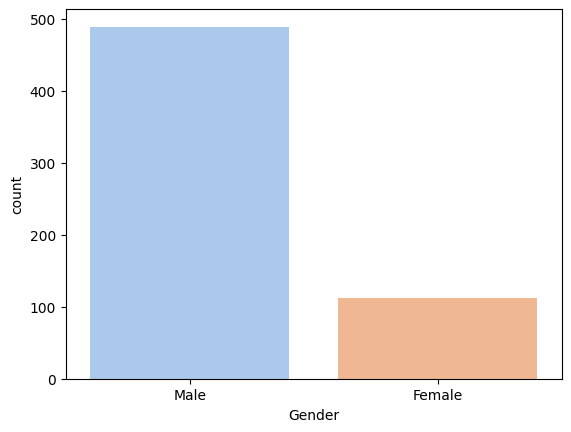

In [13]:
sns.countplot(data=df,x='Gender',palette='pastel')
plt.show()

In [14]:
percent_male = len(df[df['Gender'] == 'Male']) / len(df['Gender']) * 100
percent_female = len(df[df['Gender'] == 'Female']) / len(df['Gender']) * 100
percent_na = len(df[df['Gender'].isna()]) / len(df['Gender']) * 100

print(f'The Percentage of Male is {percent_male:.2f}%')
print(f'The Percentage of Female is {percent_female:.2f}%')
print(f'The Percentage of Missing Value is {percent_na:.2f}%')

The Percentage of Male is 79.64%
The Percentage of Female is 18.24%
The Percentage of Missing Value is 2.12%


### Married

In [15]:
df['Married'].value_counts(dropna=False)

Married
Yes    398
No     213
NaN      3
Name: count, dtype: int64

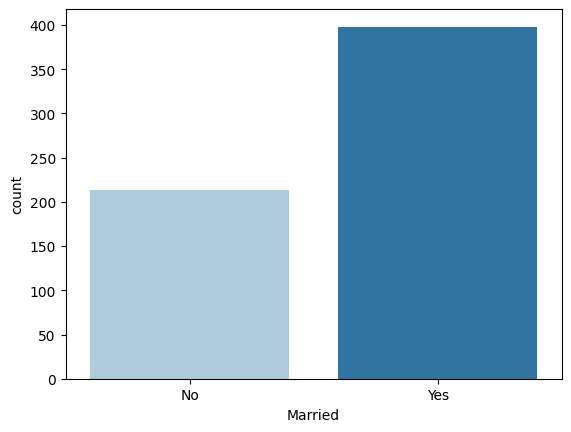

In [16]:
sns.countplot(data=df,x='Married',palette='Paired')
plt.show()

In [17]:
percent_married = len(df[df['Married'] == 'Yes']) / len(df['Married']) * 100
percent_not_married = len(df[df['Married'] == 'No']) / len(df['Married']) * 100
percent_na = len(df[df['Married'].isna()]) / len(df['Married']) * 100

print(f'The Percentage of Married is {percent_married:.2f}%')
print(f'The Percentage of Not Married is {percent_not_married:.2f}%')
print(f'The Percentage of Missing Value is {percent_na:.2f}%')

The Percentage of Married is 64.82%
The Percentage of Not Married is 34.69%
The Percentage of Missing Value is 0.49%


### Dependents

In [18]:
df['Dependents'].value_counts(dropna=False)

Dependents
0      345
1      102
2      101
3+      51
NaN     15
Name: count, dtype: int64

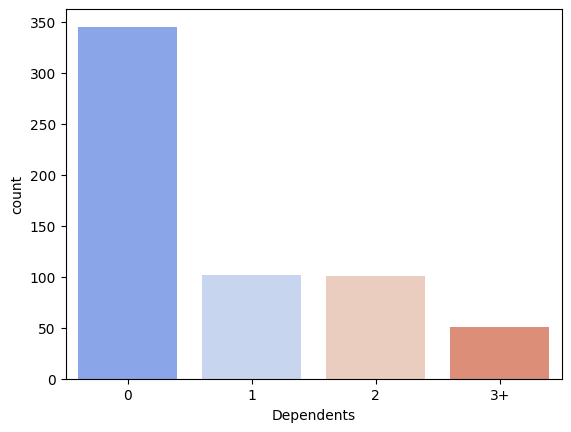

In [19]:
sns.countplot(data=df,x='Dependents',palette='coolwarm')
plt.show()

In [20]:
percent_0 = len(df[df['Dependents'] == '0']) / len(df['Dependents']) * 100
percent_1 = len(df[df['Dependents'] == '1']) / len(df['Dependents']) * 100
percent_2 = len(df[df['Dependents'] == '2']) / len(df['Dependents']) * 100
percent_3_plus = len(df[df['Dependents'] == '3+']) / len(df['Dependents']) *100
percent_na = len(df[df['Dependents'].isna()]) / len(df['Dependents']) * 100

print(f'The Percentage of 0 is {percent_0:.2f}%')
print(f'The Percentage of 1 is {percent_1:.2f}%')
print(f'The Percentage of 2 is {percent_2:.2f}%')
print(f'The Percentage of 3+ is {percent_3_plus:.2f}%')
print(f'The Percentage of Missing Value is {percent_na:.2f}%')

The Percentage of 0 is 56.19%
The Percentage of 1 is 16.61%
The Percentage of 2 is 16.45%
The Percentage of 3+ is 8.31%
The Percentage of Missing Value is 2.44%


### Education

In [21]:
df['Education'].value_counts(dropna=False)

Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64

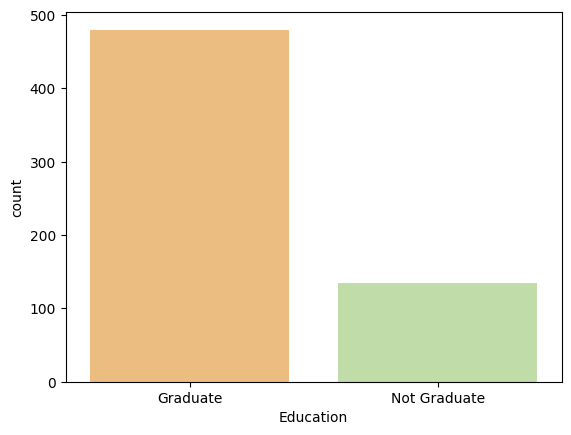

In [22]:
sns.countplot(data=df,x='Education',palette='Spectral')
plt.show()

In [23]:
percent_graduate = len(df[df['Education'] == 'Graduate']) / len(df['Education']) * 100
percent_not_graduate = len(df[df['Education'] == 'Not Graduate']) / len(df['Education']) * 100

print(f'The Percentage of Graduate is {percent_graduate:.2f}%')
print(f'The Percentage of Not Graduate is {percent_not_graduate:.2f}%')

The Percentage of Graduate is 78.18%
The Percentage of Not Graduate is 21.82%


### Self Employed

In [24]:
df['Self_Employed'].value_counts(dropna=False)

Self_Employed
No     500
Yes     82
NaN     32
Name: count, dtype: int64

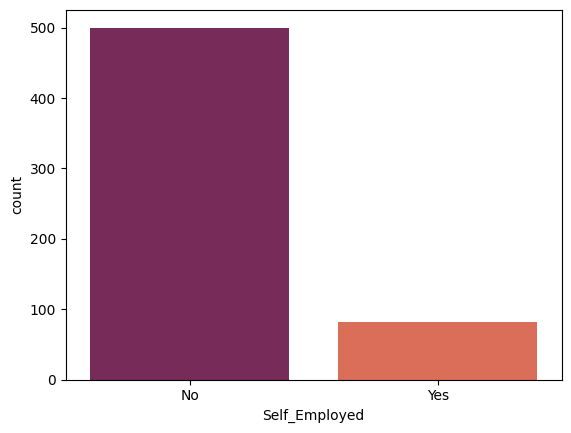

In [25]:
sns.countplot(data=df,x='Self_Employed',palette='rocket')
plt.show()

In [26]:
percent_yes = len(df[df['Self_Employed'] == 'Yes']) / len(df['Self_Employed']) * 100
percent_no = len(df[df['Self_Employed'] == 'No']) / len(df['Self_Employed']) * 100
percent_na = len(df[df['Self_Employed'].isna()]) / len(df['Self_Employed']) * 100

print(f'The Percentage of Self_Employed is {percent_yes:.2f}%')
print(f'The Percentage of Un Self_Employed is {percent_no:.2f}%')
print(f'The Percentage of Missing Value is {percent_na:.2f}%')

The Percentage of Self_Employed is 13.36%
The Percentage of Un Self_Employed is 81.43%
The Percentage of Missing Value is 5.21%


### Credit History

In [27]:
df['Credit_History'].value_counts(dropna=False)

Credit_History
1.0    475
0.0     89
NaN     50
Name: count, dtype: int64

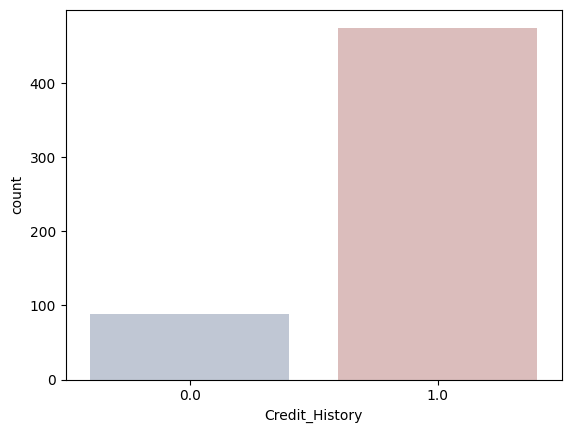

In [28]:
sns.countplot(data=df,x='Credit_History',palette='vlag')
plt.show()

In [29]:
percent_1 = len(df[df['Credit_History'] == 1]) / len(df['Credit_History']) * 100
percent_0 = len(df[df['Credit_History'] == 0]) / len(df['Credit_History']) * 100
percent_na = len(df[df['Credit_History'].isna()]) / len(df['Credit_History']) * 100

print(f'The Percentage of Good History is {percent_1:.2f}%')
print(f'The Percentage of Bad History is {percent_0:.2f}%')
print(f'THe Percentage of Missing Value is {percent_na:.2f}%')

The Percentage of Good History is 77.36%
The Percentage of Bad History is 14.50%
THe Percentage of Missing Value is 8.14%


### Property Area

In [30]:
df['Property_Area'].value_counts(dropna=False)

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64

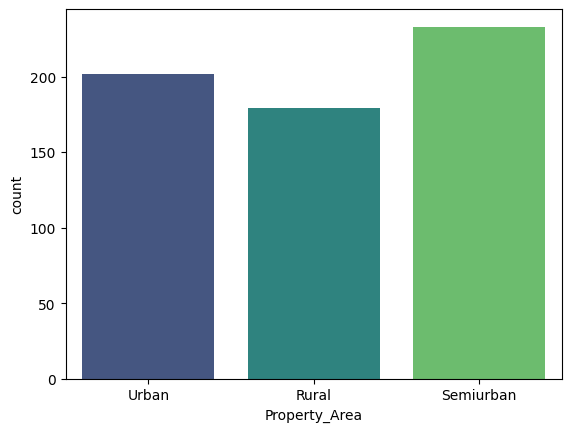

In [31]:
sns.countplot(data=df,x='Property_Area',palette='viridis')
plt.show()

In [32]:
percent_urban = len(df[df['Property_Area'] == 'Urban']) / len(df['Property_Area']) * 100
percent_rural = len(df[df['Property_Area'] == 'Rural']) / len(df['Property_Area']) * 100
percent_semiurban = len(df[df['Property_Area'] == 'Semiurban']) / len(df['Property_Area']) * 100

print(f'The Percentage of Urban is {percent_urban:.2f}%')
print(f'The Percentage of Rural is {percent_rural:.2f}%')
print(f'The Percentage of Semiurban is {percent_semiurban:.2f}%')

The Percentage of Urban is 32.90%
The Percentage of Rural is 29.15%
The Percentage of Semiurban is 37.95%


### Loan Amount Term

In [33]:
df['Loan_Amount_Term'].value_counts(dropna=False)

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
NaN       14
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

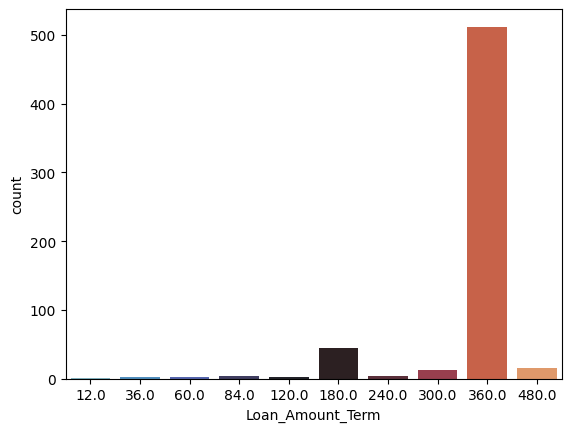

In [34]:
sns.countplot(data=df,x='Loan_Amount_Term',palette='icefire')
plt.show()

In [35]:
def calculate_percentage(df, term):

    # 計算特定term的百分比
    count = len(df[df['Loan_Amount_Term'] == term])
    total = len(df['Loan_Amount_Term'])

    return (count/total)*100 if total > 0 else 0

terms = [12,36,60,84,120,180,240,300,360,480]

for term in terms:
    percentage = calculate_percentage(df, term)

    print(f'The Percentage of {term} Days is {percentage:.2f}%')

The Percentage of 12 Days is 0.16%
The Percentage of 36 Days is 0.33%
The Percentage of 60 Days is 0.33%
The Percentage of 84 Days is 0.65%
The Percentage of 120 Days is 0.49%
The Percentage of 180 Days is 7.17%
The Percentage of 240 Days is 0.65%
The Percentage of 300 Days is 2.12%
The Percentage of 360 Days is 83.39%
The Percentage of 480 Days is 2.44%


## Describe Numerical Data

In [36]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


#### The table provides the following information:
1. LoanAmount has only 592 entries out of a total of 614, indicating Missing Values.
2. The Max values of these three variables are all greater than 75%, indicating the presence of Outliers.
3. For CoapplicantIncome, the Min and 25th percentile are both 0, suggesting that at least 25% of co-applicants have no income, which may affect the success rate of loans.
4. The standard deviations of these three variables are not low, especially for ApplicantIncome & CoapplicantIncome, indicating a wide range of values.

#### Outliers should be noted.

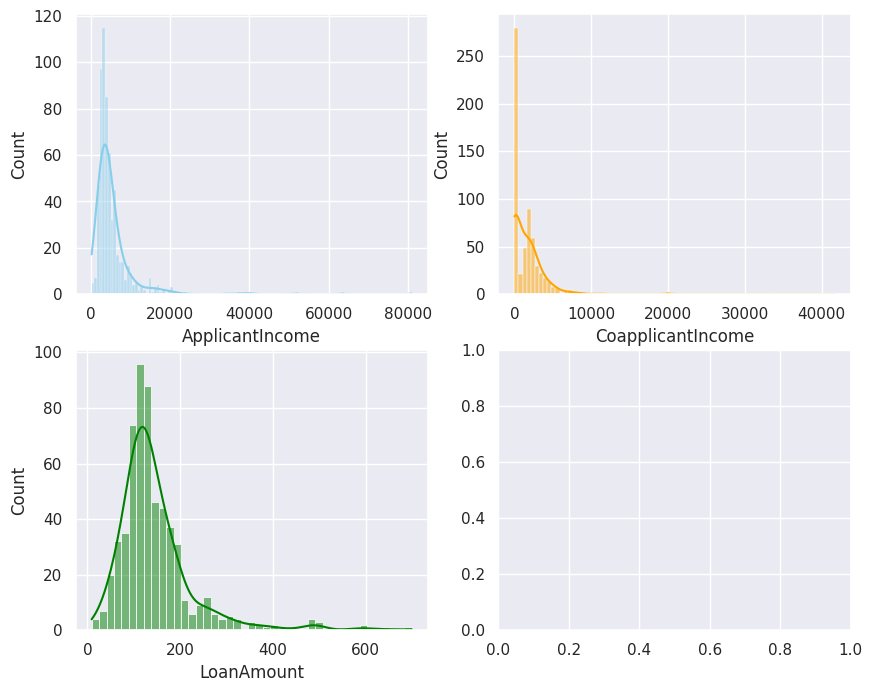

In [37]:
sns.set(style='darkgrid')

fig, axs = plt.subplots(2,2,figsize=(10,8))

sns.histplot(data=df, x='ApplicantIncome', kde=True, ax=axs[0,0], color='skyblue')
sns.histplot(data=df, x='CoapplicantIncome', kde=True, ax=axs[0,1], color='orange')
sns.histplot(data=df, x='LoanAmount', kde=True, ax=axs[1,0], color='green')
plt.show()

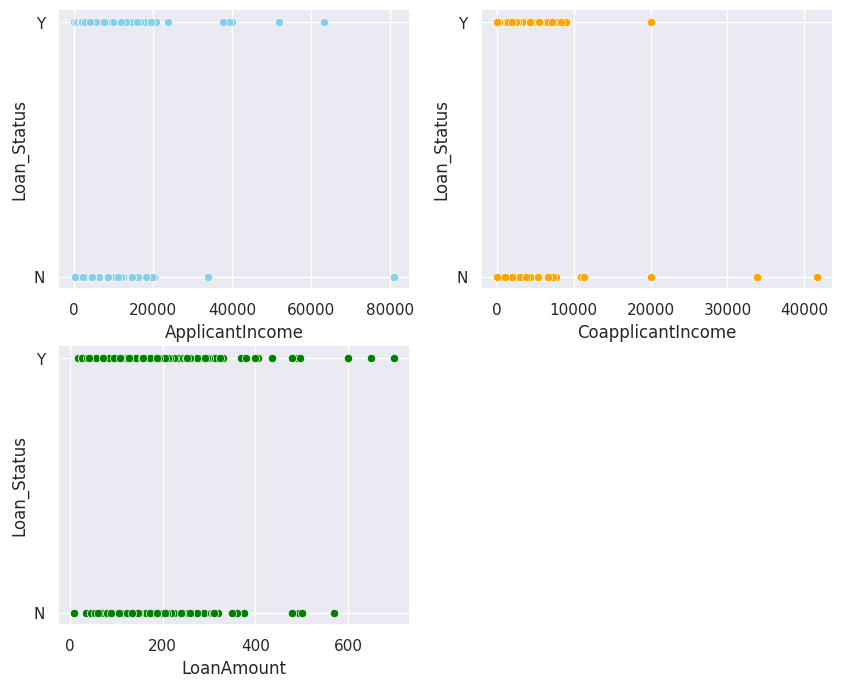

In [38]:
sns.set(style='darkgrid')

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.scatterplot(data=df, x='ApplicantIncome', y='Loan_Status', ax=axs[0, 0], color='skyblue')
sns.scatterplot(data=df, x='CoapplicantIncome', y='Loan_Status', ax=axs[0, 1], color='orange')
sns.scatterplot(data=df, x='LoanAmount', y='Loan_Status', ax=axs[1, 0], color='green')

axs[1, 1].set_visible(False)

plt.show()


In [39]:
df.corr(numeric_only=True)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000


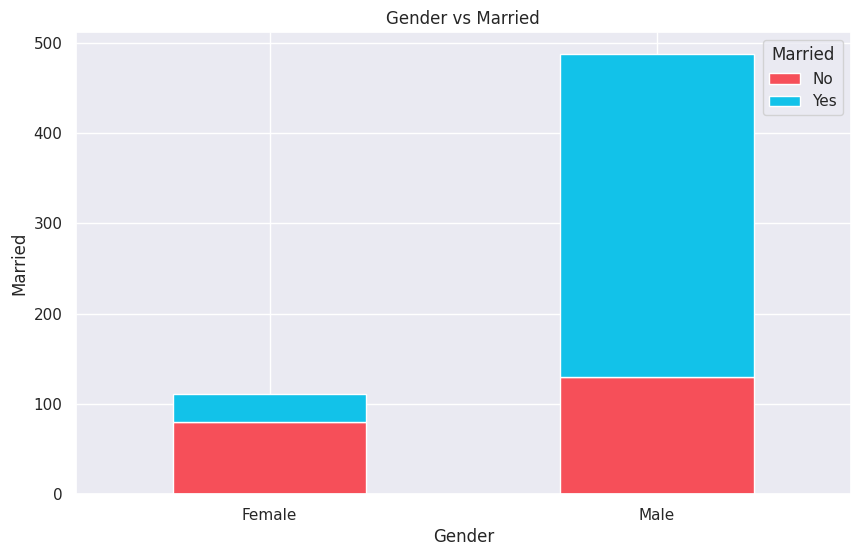

In [40]:
pd.crosstab(df['Gender'], df['Married']).plot(kind='bar', stacked=True, figsize=(10,6), color=['#f64f59','#12c2e9'])

plt.title('Gender vs Married')
plt.xlabel('Gender')
plt.ylabel('Married')
plt.xticks(rotation=0)
plt.show()

#### Most men applying for loans are already married, and the majority of loan applicants are married.
#### Considering that marriage often leads to buying a house or increased living expenses, this seems reasonable.

### Self Employed vs Credit History

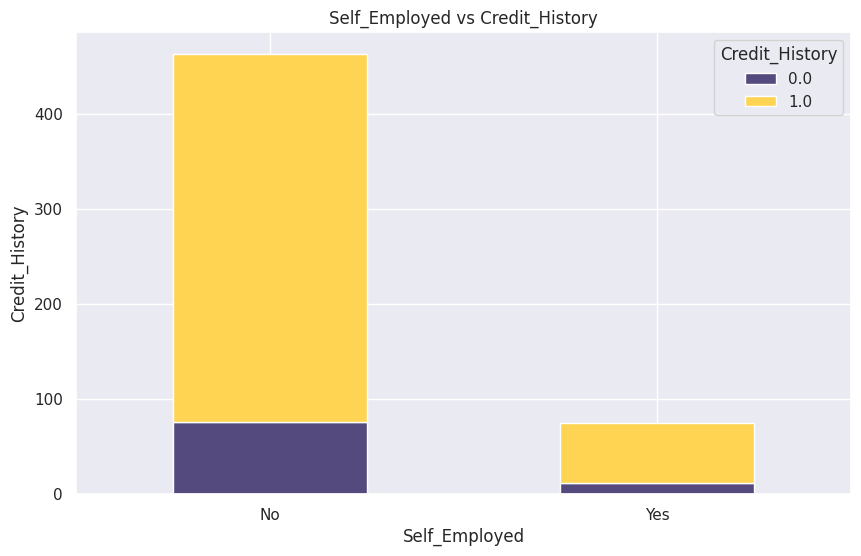

In [41]:
pd.crosstab(df['Self_Employed'], df['Credit_History']).plot(kind='bar', stacked=True, figsize=(10,6),
                                                           color=['#544a7d','#ffd452'])
plt.title('Self_Employed vs Credit_History')
plt.xlabel('Self_Employed')
plt.ylabel('Credit_History')
plt.xticks(rotation=0)
plt.show()

In [42]:
cross_table = pd.crosstab(df['Self_Employed'],df['Credit_History'])

print(cross_table)

Credit_History  0.0  1.0
Self_Employed           
No               76  387
Yes              12   63


In [43]:
good_credit_self_employed = cross_table.loc['Yes',1]
bad_credit_self_employed = cross_table.loc['Yes',0]

good_credit_un_self_employed = cross_table.loc['No',1]
bad_credit_un_self_employed = cross_table.loc['No',0]

print(f'These are the number of Self_Employed that had Good Credit History: {good_credit_self_employed}')
print(f'These are the number of Self_Employed that had Bad Credit History: {bad_credit_self_employed}')

print(f'These are the number of UnSelf_Employed that had Good Credit History: {good_credit_un_self_employed}')
print(f'These are the number of UnSelf_Employed that had Bad Credit History: {bad_credit_un_self_employed}')

These are the number of Self_Employed that had Good Credit History: 63
These are the number of Self_Employed that had Bad Credit History: 12
These are the number of UnSelf_Employed that had Good Credit History: 387
These are the number of UnSelf_Employed that had Bad Credit History: 76


### Property Area vs Loan Status

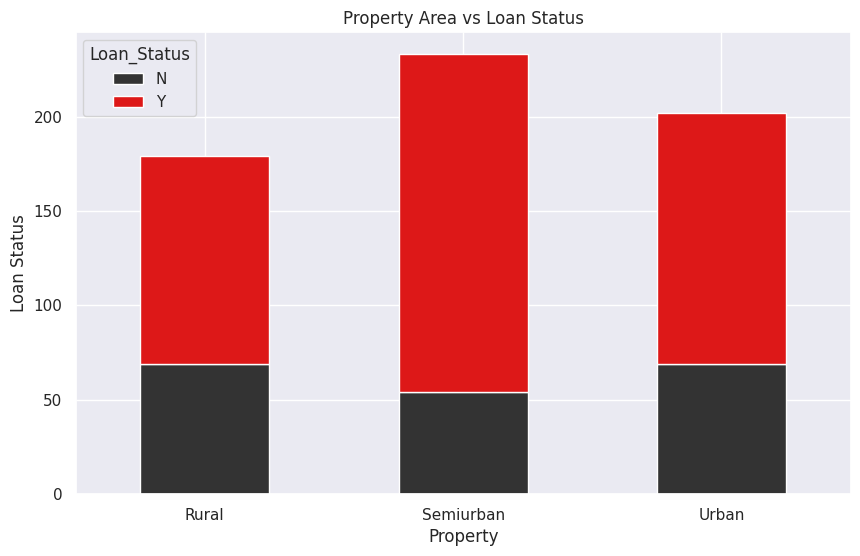

In [44]:
pd.crosstab(df['Property_Area'],df['Loan_Status']).plot(kind='bar', stacked=True, figsize=(10,6),
                                                       color=['#333333','#dd1818'])
plt.title('Property Area vs Loan Status')
plt.xlabel('Property')
plt.ylabel('Loan Status')
plt.xticks(rotation=0)
plt.show()

## Numeric data ompare with Loan Stauts

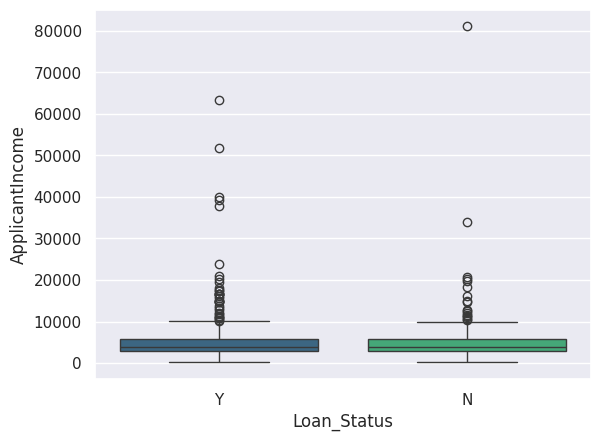

In [45]:
sns.boxplot(data=df,x='Loan_Status',y='ApplicantIncome',palette='viridis')
plt.show()

In [46]:
df.groupby('Loan_Status')['ApplicantIncome'].describe()

,count,mean,std,min,25%,50%,75%,max
Loan_Status,,,,,,,,
N,192.0,5446.078125,6819.558528,150.0,2885.0,3833.5,5861.25,81000.0
Y,422.0,5384.068720,5765.441615,210.0,2877.5,3812.5,5771.50,63337.0


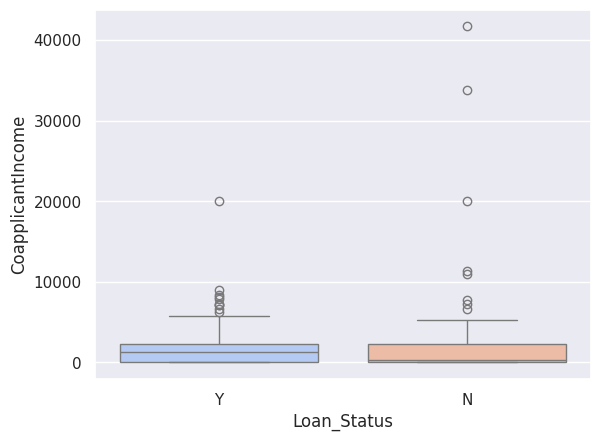

In [47]:
sns.boxplot(data=df,x='Loan_Status',y='CoapplicantIncome',palette='coolwarm')
plt.show()

In [48]:
df.groupby('Loan_Status')['CoapplicantIncome'].describe()

,count,mean,std,min,25%,50%,75%,max
Loan_Status,,,,,,,,
N,192.0,1877.807292,4384.060103,0.0,0.0,268.0,2273.75,41667.0
Y,422.0,1504.516398,1924.754855,0.0,0.0,1239.5,2297.25,20000.0


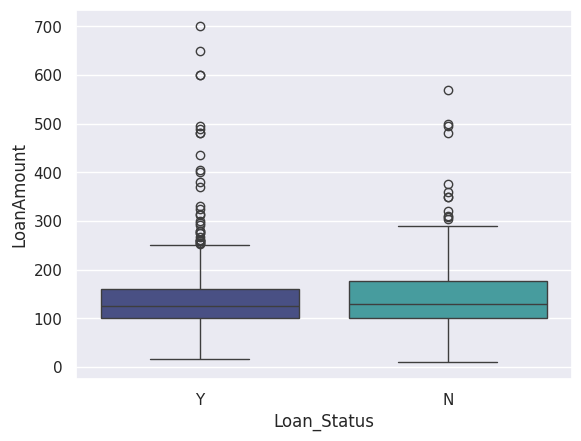

In [49]:
sns.boxplot(data=df,x='Loan_Status',y='LoanAmount',palette='mako')
plt.show()

In [50]:
df.groupby('Loan_Status')['LoanAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
Loan_Status,,,,,,,,
N,181.0,151.220994,85.862783,9.0,100.0,129.0,176.0,570.0
Y,411.0,144.294404,85.484607,17.0,100.0,126.0,161.0,700.0


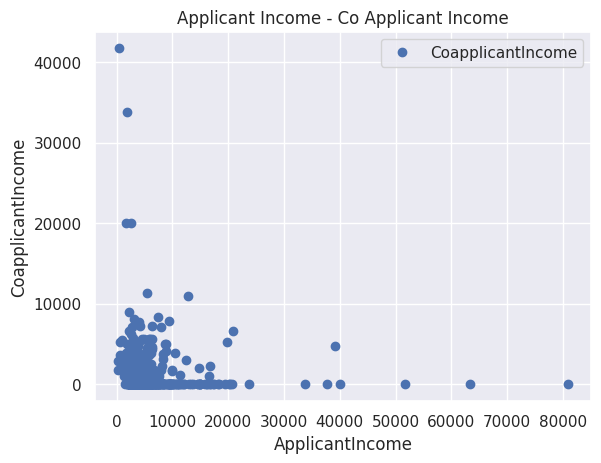

Pearson correlation: -0.11660458122889966
T Test and P Value: 
 TtestResult(statistic=13.835753259915665, pvalue=1.460983948423972e-40, df=1226.0)


In [51]:
df.plot(x='ApplicantIncome', y='CoapplicantIncome', style='o')
plt.title('Applicant Income - Co Applicant Income')
plt.xlabel('ApplicantIncome')
plt.ylabel('CoapplicantIncome')
plt.show()

print('Pearson correlation:', df['ApplicantIncome'].corr(df['CoapplicantIncome']))
print('T Test and P Value: \n', stats.ttest_ind(df['ApplicantIncome'], df['CoapplicantIncome']))

#### The very small p-value indicates a significant difference (Reject Null Hypothesis).

* Although the Pearson correlation coefficient between ApplicantIncome and CoapplicantIncome shows a slight negative correlation, this relationship is very weak and almost negligible.

* However, the results of the T-Test clearly indicate a significant difference in the means of the two sets of data.

* This may suggest that while the correlation between the two is not strong to some extent, they exhibit significant differences in magnitude or distribution.

* This information could be very useful for understanding the income characteristics of individuals applying for loans, especially when evaluating the financial status of applicants and co-applicants during the loan approval process.

## Feature Engineering

In [52]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

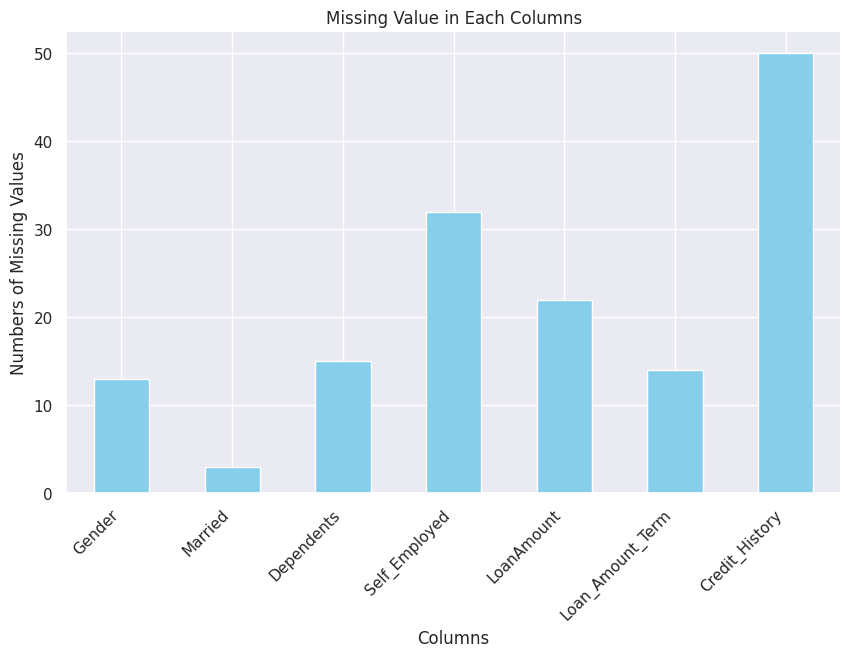

In [53]:
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(10,6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Value in Each Columns')
plt.xlabel('Columns')
plt.ylabel('Numbers of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()

In [54]:
# drop unecessary values
df = df.drop('Loan_ID', axis=1)

In [55]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [56]:
# Categorical data use mode to fill into missing value
# Moreover, it is less susceptible to the influence of outliers, making it suitable for handling categorical data.
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [57]:
# Numerical data use mean to fill into missing value
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

In [58]:
df = pd.get_dummies(df).astype(int)

df

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
0,5849,0,146,360,1,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
1,4583,1508,128,360,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3000,0,66,360,1,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,2583,2358,120,360,1,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,6000,0,141,360,1,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0,71,360,1,1,0,1,0,1,...,0,1,0,1,0,1,0,0,0,1
610,4106,0,40,180,1,0,1,0,1,0,...,1,1,0,1,0,1,0,0,0,1
611,8072,240,253,360,1,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1
612,7583,0,187,360,1,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1


In [59]:
# Drop columns
df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 'Self_Employed_No',
              'Loan_Status_N'], axis=1)

# Rename new columns
new = {'Gender_Male':'Gender', 'Married_Yes':'Married', 'Education_Graduate':'Education',
       'Self_Employed_Yes':'Self_Employed', 'Loan_Status_Y':'Loan_Status'}


df.rename(columns=new, inplace=True)

In [60]:
df['Self_Employed'].value_counts()

Self_Employed
0    532
1     82
Name: count, dtype: int64

In [61]:
df

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education,Self_Employed,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,5849,0,146,360,1,1,0,1,0,0,0,1,0,0,0,1,1
1,4583,1508,128,360,1,1,1,0,1,0,0,1,0,1,0,0,0
2,3000,0,66,360,1,1,1,1,0,0,0,1,1,0,0,1,1
3,2583,2358,120,360,1,1,1,1,0,0,0,0,0,0,0,1,1
4,6000,0,141,360,1,1,0,1,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0,71,360,1,0,0,1,0,0,0,1,0,1,0,0,1
610,4106,0,40,180,1,1,1,0,0,0,1,1,0,1,0,0,1
611,8072,240,253,360,1,1,1,0,1,0,0,1,0,0,0,1,1
612,7583,0,187,360,1,1,1,0,0,1,0,1,0,0,0,1,1


In [62]:
df['Loan_Status'].value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

In [63]:
df

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education,Self_Employed,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,5849,0,146,360,1,1,0,1,0,0,0,1,0,0,0,1,1
1,4583,1508,128,360,1,1,1,0,1,0,0,1,0,1,0,0,0
2,3000,0,66,360,1,1,1,1,0,0,0,1,1,0,0,1,1
3,2583,2358,120,360,1,1,1,1,0,0,0,0,0,0,0,1,1
4,6000,0,141,360,1,1,0,1,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0,71,360,1,0,0,1,0,0,0,1,0,1,0,0,1
610,4106,0,40,180,1,1,1,0,0,0,1,1,0,1,0,0,1
611,8072,240,253,360,1,1,1,0,1,0,0,1,0,0,0,1,1
612,7583,0,187,360,1,1,1,0,0,1,0,1,0,0,0,1,1


In [64]:
# Use square root to normalize data
df['ApplicantIncome'] = np.sqrt(df['ApplicantIncome'])
df['CoapplicantIncome'] = np.sqrt(df['CoapplicantIncome'])
df['LoanAmount'] = np.sqrt(df['LoanAmount'])

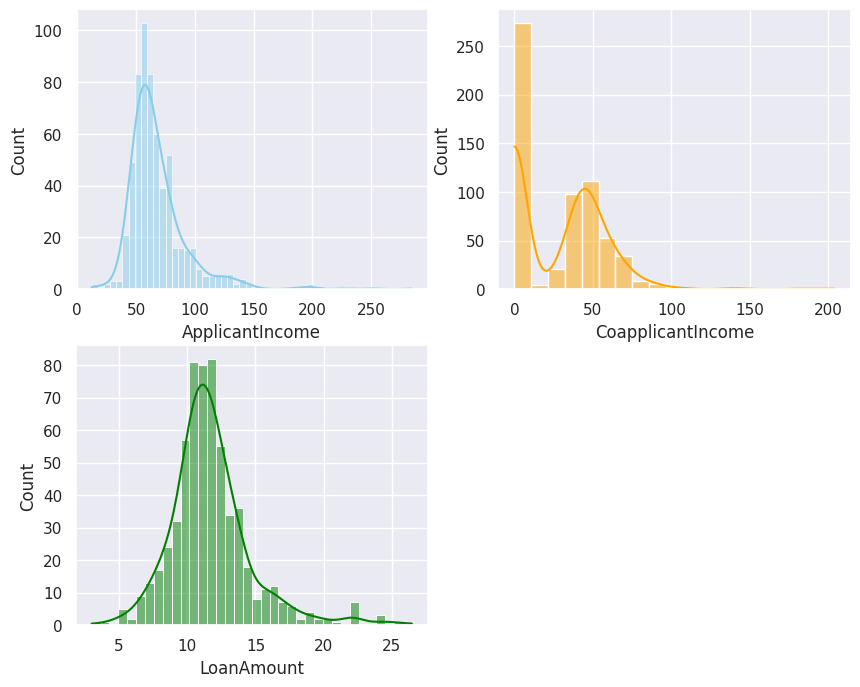

In [65]:
# Looks like it is better after using sqrt
sns.set(style='darkgrid')
fig, axs = plt.subplots(2,2, figsize=(10,8))

sns.histplot(data=df, x='ApplicantIncome', kde=True, ax=axs[0,0], color='skyblue')
sns.histplot(data=df, x='CoapplicantIncome', kde=True, ax=axs[0,1], color='orange')
sns.histplot(data=df, x='LoanAmount', kde=True, ax=axs[1,0], color='green')

axs[1,1].set_visible(False)

plt.show()

In [66]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

## Dealing with Outliers

In [67]:
# detect outliers, use 5 models to evaluate

def detect_outliers(X, contamination=0.1):
    models = {
        'KNN': KNN(contamination=contamination),
        'ECOD': ECOD(contamination=contamination),
        'IForest': IForest(contamination=contamination),
        'PCA': PCA(contamination=contamination),
        'LOF': LOF(contamination=contamination)
    }
    outliers = {}
    for model_name, model in models.items():
        model.fit(X)
        outliers[model_name] = model.labels_
    return outliers

In [68]:
detect_outliers(df)

{'KNN': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1,

In [69]:
# This function find_best_threshold iterates through a range of thresholds to find the optimal threshold
# for anomaly detection models. It evaluates each threshold using stratified k-fold cross-validation and
# selects the threshold that maximizes the F1 score.
def find_best_threshold(X, y, models, start=0.1, end=0.5, step=0.1, n_splits=5):
    best_threshold = start
    best_f1_score = -1

    thresholds = np.arange(start, end, step)
    skf = StratifiedKFold(n_splits=n_splits)

    for threshold in thresholds:
        temp_f1_scores = []
        for train_index, test_index in skf.split(X, y):

            if isinstance(X, pd.DataFrame):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            else:
                X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            temp_models = {name: clf.set_params(contamination=threshold) for name, clf in models.items()}
            for model_name, model in temp_models.items():
                model.fit(X_train)
                y_pred = model.predict(X_test)
                temp_f1_scores.append(f1_score(y_test, y_pred))

        avg_f1_score = np.mean(temp_f1_scores)
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_threshold = threshold

    return best_threshold

In [70]:
models = {
    'KNN': KNN(contamination=0.1),
    'ECOD': ECOD(contamination=0.1),
    'IForest': IForest(contamination=0.1),
    'PCA': PCA(contamination=0.1),
    'LOF': LOF(contamination=0.1)}

best_threshold = find_best_threshold(X, y.values, models)

print(f'Best contamination threshold: {best_threshold}')

Best contamination threshold: 0.4


In [71]:
detect_outliers(X, 0.4)

{'KNN': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1,

In [72]:
def combined_outliers(outliers, strategy='all'):

    if strategy == 'all':
        return np.any(list(outliers.values()), axis=0)
    elif strategy == 'union':
        return np.any(list(outliers.values()), axis=0)
    elif strategy == 'intersection':
        return np.all(list(outliers.values()), axis=0)

In [73]:
# show the outliers
outliers = detect_outliers(X, 0.4)

combined_outliers(outliers, strategy='all')

combined_result = combined_outliers(outliers, strategy='all')

combined_result_int = combined_result.astype(int)
combined_result_int

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

In [74]:
strategy = 'all'
outliers_selected = combined_outliers(outliers, strategy=strategy)

retain_ratio = 0.5
non_outliers_selected = ~outliers_selected
sampled_outliers = np.random.choice(np.where(outliers_selected)[0], int(sum(outliers_selected) * retain_ratio), replace=False)
sampled_outliers_selected = np.zeros(len(outliers_selected), dtype=bool)
sampled_outliers_selected[sampled_outliers] = True

final_selected = non_outliers_selected | sampled_outliers_selected

filtered_X = X[final_selected]
filtered_y = y[final_selected]

## Train Test Split & Normalization

In [75]:
X_train, X_test, y_train, y_test = train_test_split(filtered_X, filtered_y, test_size=0.2, random_state=42)

## Built Model

In [79]:
models = [('RandomForest', RandomForestClassifier(random_state=42)),
          ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
          ('SVM', SVC(random_state=42)),
          ('KNN', KNeighborsClassifier()),
          ('AdaBoost', AdaBoostClassifier(random_state=42)),
          ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]

results = {}

for model_name, model in models:

    pipline = ImbPipeline([('scaler', MinMaxScaler()), ('SMOTE',SMOTE(random_state=42)),(model_name, model)])

    # Not using X_train_resampled is to avoid data leakage. Additionally,
    # resampling is performed for each cross-validation iteration.
    cv_score = cross_val_score(pipline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    results[f'{model_name}'] = np.mean(cv_score)

for result in sorted(results, key=results.get, reverse=True):
    print(f'{result}: {results[result]*100:.2f}%')

SVM: 76.36%
LogisticRegression: 75.45%
RandomForest: 72.42%
AdaBoost: 72.12%
XGBoost: 70.91%
KNN: 69.09%


### Logistic Regression

In [80]:
# Use Bayesian optimization

def objection(max_iter, C):

    max_iter = int(max_iter)

    model = LogisticRegression(penalty='l2', max_iter=max_iter, C=C, solver='lbfgs', random_state=42)

    log_pipeline = ImbPipeline([('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=42)), ('model', model)])

    score = cross_val_score(log_pipeline, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(score)

pbounds = {'max_iter':(100,1000), 'C':(0.01,100)}

optimizer = BayesianOptimization(f=objection, pbounds=pbounds, random_state=42)

optimizer.maximize(init_points=20, n_iter=60)

print(optimizer.max)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.7606    | 37.46     | 955.6     |
| 2         | 0.7606    | 73.2      | 638.8     |
| 3         | 0.7576    | 15.61     | 240.4     |
| 4         | 0.7636    | 5.818     | 879.6     |
| 5         | 0.7606    | 60.12     | 737.3     |
| 6         | 0.7606    | 2.068     | 972.9     |
| 7         | 0.7606    | 83.25     | 291.1     |
| 8         | 0.7576    | 18.19     | 265.1     |
| 9         | 0.7576    | 30.43     | 572.3     |
| 10        | 0.7606    | 43.2      | 362.1     |
| 11        | 0.7606    | 61.19     | 225.5     |
| 12        | 0.7576    | 29.22     | 429.7     |
| 13        | 0.7606    | 45.61     | 806.7     |
| 14        | 0.7576    | 19.98     | 562.8     |
| 15        | 0.7606    | 59.25     | 141.8     |
| 16        | 0.7606    | 60.76     | 253.5     |
| 17        | 0.7636    | 6.515     | 954.0     |
| 18        | 0.7606    | 96.56     | 827.6     |


In [81]:
best_params = {'max_iter':int(optimizer.max['params']['max_iter']),
               'C':optimizer.max['params']['C'],}

model = LogisticRegression(**best_params, penalty='l2', solver='lbfgs', random_state=42)

log_pipeline = ImbPipeline([('smote', SMOTE(random_state=42)),('model', model)])

log_pipeline.fit(X_train, y_train)

log_prediciton = log_pipeline.predict(X_test)

print(f'LogisticRegression Training Score is: {log_pipeline.score(X_train, y_train) * 100:.2f}%')
print(f'LogisticRegression Accuracy Score is: {accuracy_score(y_test, log_prediciton) * 100:.2f}%')
print(classification_report(y_test, log_prediciton))


LogisticRegression Training Score is: 82.12%
LogisticRegression Accuracy Score is: 81.93%
              precision    recall  f1-score   support

           0       0.73      0.40      0.52        20
           1       0.83      0.95      0.89        63

    accuracy                           0.82        83
   macro avg       0.78      0.68      0.70        83
weighted avg       0.81      0.82      0.80        83



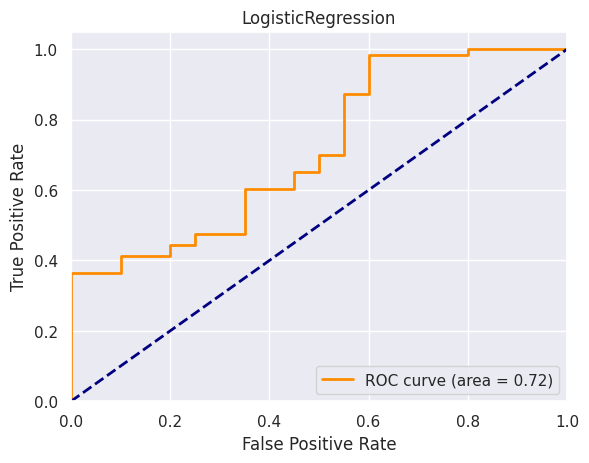

AUC: 0.72


In [82]:
y_pred_proba = log_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

### Random Forest

In [83]:
# Use Bayesian optimization

def objection(n_estimators, max_depth, min_samples_split, min_samples_leaf):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features='sqrt', random_state=42)

    rfc_pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])

    score = cross_val_score(rfc_pipeline, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(score)

pbounds = {'n_estimators':(100,1000), 'max_depth':(10,30), 'min_samples_split':(2,20), 'min_samples_leaf':(1,20)}

optimizer = BayesianOptimization(f=objection, pbounds=pbounds, random_state=42)

optimizer.maximize(init_points=20, n_iter=40)

print(optimizer.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7758    | 17.49     | 19.06     | 15.18     | 638.8     |
| 2         | 0.7667    | 13.12     | 3.964     | 3.046     | 879.6     |
| 3         | 0.7788    | 22.02     | 14.45     | 2.371     | 972.9     |
| 4         | 0.7697    | 26.65     | 5.034     | 5.273     | 265.1     |
| 5         | 0.7606    | 16.08     | 10.97     | 9.775     | 362.1     |
| 6         | 0.7576    | 22.24     | 3.65      | 7.259     | 429.7     |
| 7         | 0.7727    | 19.12     | 15.92     | 5.594     | 562.8     |
| 8         | 0.7545    | 21.85     | 1.883     | 12.94     | 253.5     |
| 9         | 0.7758    | 11.3      | 19.03     | 19.38     | 827.6     |
| 10        | 0.7636    | 16.09     | 2.856     | 14.32     | 496.1     |
| 11        | 0.7667    | 12.44     | 10.41     | 2.619     | 918.4     |
| 12        | 0.7727    | 15.18     | 

In [84]:
best_params = {'n_estimators':int(optimizer.max['params']['n_estimators']),
               'max_depth':int(optimizer.max['params']['max_depth']),
               'min_samples_split':int(optimizer.max['params']['min_samples_split']),
               'min_samples_leaf':int(optimizer.max['params']['min_samples_leaf']),
               'max_features':'sqrt'}

model = RandomForestClassifier(**best_params, random_state=42)

rfc_pipeline = ImbPipeline([('smote', SMOTE(random_state=42)),('model', model)])

rfc_pipeline.fit(X_train, y_train)

rfc_prediciton = rfc_pipeline.predict(X_test)

print(f'RandomForest Training Score is: {rfc_pipeline.score(X_train, y_train) * 100:.2f}%')
print(f'RandomForest Accuracy Score is: {accuracy_score(y_test, rfc_prediciton) * 100:.2f}%')
print(classification_report(y_test, rfc_prediciton))

RandomForest Training Score is: 83.94%
RandomForest Accuracy Score is: 81.93%
              precision    recall  f1-score   support

           0       0.73      0.40      0.52        20
           1       0.83      0.95      0.89        63

    accuracy                           0.82        83
   macro avg       0.78      0.68      0.70        83
weighted avg       0.81      0.82      0.80        83



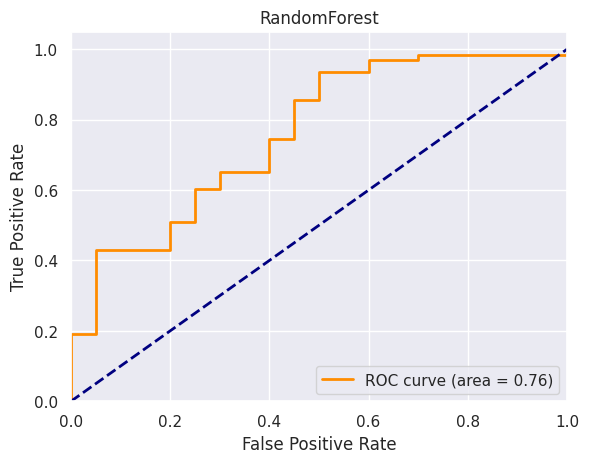

AUC: 0.76


In [85]:
y_pred_proba = rfc_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

### XGBoost

In [86]:
def objection(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    gamma = int(gamma)

    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                          subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)

    xgb_pipeline = ImbPipeline([('adasyn', ADASYN(random_state=42)),('model', model)])

    score = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(score)

pbounds = {'n_estimators':(100,1000), 'learning_rate':(0.01,0.3), 'max_depth':(3,10),
           'subsample':(0.5,1.0), 'colsample_bytree':(0.5,1.0),'gamma':(0,5)}

optimizer = BayesianOptimization(f=objection, pbounds=pbounds, random_state=42)

optimizer.maximize(init_points=20, n_iter=40)

print(optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7394    | 0.6873    | 4.754     | 0.2223    | 7.191     | 240.4     | 0.578     |
| 2         | 0.7909    | 0.529     | 4.331     | 0.1843    | 7.957     | 118.5     | 0.985     |
| 3         | 0.7606    | 0.9162    | 1.062     | 0.06273   | 4.284     | 373.8     | 0.7624    |
| 4         | 0.7394    | 0.716     | 1.456     | 0.1874    | 3.976     | 362.9     | 0.6832    |
| 5         | 0.7394    | 0.728     | 3.926     | 0.06791   | 6.6       | 633.2     | 0.5232    |
| 6         | 0.7636    | 0.8038    | 0.8526    | 0.02886   | 9.642     | 969.1     | 0.9042    |
| 7         | 0.7636    | 0.6523    | 0.4884    | 0.2084    | 6.081     | 209.8     | 0.7476    |
| 8         | 0.7697    | 0.5172    | 4.547     | 0.08505   | 7.638     | 380.5     | 0.76      |
| 9         | 0.7545

In [87]:
best_params = {'n_estimators':int(optimizer.max['params']['n_estimators']),
               'learning_rate':optimizer.max['params']['learning_rate'],
               'max_depth':int(optimizer.max['params']['max_depth']),
               'subsample':optimizer.max['params']['subsample'],
               'colsample_bytree':optimizer.max['params']['colsample_bytree'],
               'gamma':optimizer.max['params']['gamma']}

model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_pipeline = ImbPipeline([('adasyn', ADASYN(random_state=42)), ('model', model)])

xgb_pipeline.fit(X_train, y_train)

xgb_prediciton = xgb_pipeline.predict(X_test)

print(f'XGBoost Training Score is: {xgb_pipeline.score(X_train, y_train) * 100:.2f}%')
print(f'XGBoost Accuracy Score is: {accuracy_score(y_test, xgb_prediciton) * 100:.2f}%')
print(classification_report(y_test, xgb_prediciton))

XGBoost Training Score is: 83.94%
XGBoost Accuracy Score is: 83.13%
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.86      0.94      0.89        63

    accuracy                           0.83        83
   macro avg       0.78      0.72      0.74        83
weighted avg       0.82      0.83      0.82        83



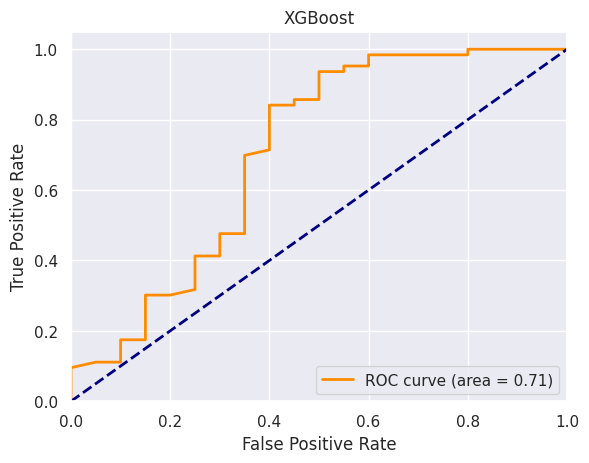

AUC: 0.71


In [88]:
y_pred_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

### AdaBoost

In [89]:
# Use Bayesian optimization

def objection(n_estimators, learning_rate):

    n_estimators = int(n_estimators)

    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    ada_pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])

    score = cross_val_score(ada_pipeline, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(score)

pbounds = {'n_estimators':(50,1000), 'learning_rate':(0.01,1)}

optimizer = BayesianOptimization(f=objection, pbounds=pbounds, random_state=42)

optimizer.maximize(init_points=20, n_iter=40)

print(optimizer.max)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.7333    | 0.3808    | 953.2     |
| 2         | 0.7182    | 0.7347    | 618.7     |
| 3         | 0.7455    | 0.1645    | 198.2     |
| 4         | 0.7545    | 0.0675    | 872.9     |
| 5         | 0.7333    | 0.6051    | 722.7     |
| 6         | 0.7576    | 0.03038   | 971.4     |
| 7         | 0.7303    | 0.8341    | 251.7     |
| 8         | 0.7515    | 0.19      | 224.2     |
| 9         | 0.7333    | 0.3112    | 548.5     |
| 10        | 0.7333    | 0.4376    | 326.7     |
| 11        | 0.7303    | 0.6157    | 182.5     |
| 12        | 0.7364    | 0.2992    | 398.0     |
| 13        | 0.7394    | 0.4615    | 795.9     |
| 14        | 0.7394    | 0.2077    | 538.5     |
| 15        | 0.7424    | 0.5965    | 94.13     |
| 16        | 0.7364    | 0.6115    | 212.0     |
| 17        | 0.7545    | 0.0744    | 951.4     |
| 18        | 0.7273    | 0.966     | 818.0     |


In [90]:
best_params = {'n_estimators':int(optimizer.max['params']['n_estimators']),
               'learning_rate':optimizer.max['params']['learning_rate']}

model = AdaBoostClassifier(**best_params, random_state=42)

ada_pipeline = ImbPipeline([('smote', SMOTE(random_state=42)),('model', model)])

ada_pipeline.fit(X_train, y_train)

ada_prediciton = ada_pipeline.predict(X_test)

print(f'AdaBoost Training Score is: {ada_pipeline.score(X_train, y_train) * 100:.2f}%')
print(f'AdaBoost Accuracy Score is: {accuracy_score(y_test, ada_prediciton) * 100:.2f}%')
print(classification_report(y_test, ada_prediciton))

AdaBoost Training Score is: 81.82%
AdaBoost Accuracy Score is: 84.34%
              precision    recall  f1-score   support

           0       0.89      0.40      0.55        20
           1       0.84      0.98      0.91        63

    accuracy                           0.84        83
   macro avg       0.86      0.69      0.73        83
weighted avg       0.85      0.84      0.82        83



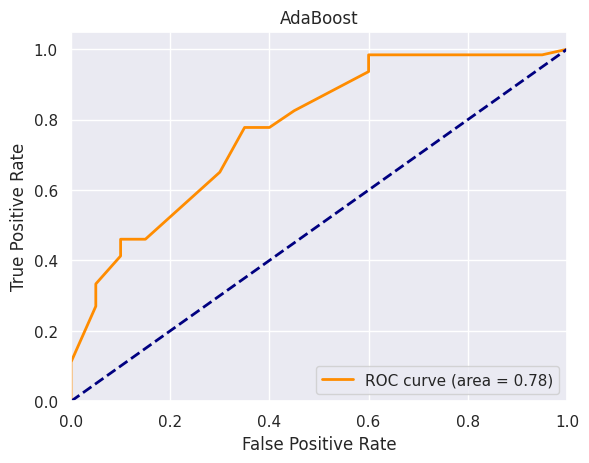

AUC: 0.78


In [91]:
y_pred_proba = ada_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

### SVC

In [92]:
# Use Bayesian optimization

def objection(C):

    model = SVC(C=C, kernel='rbf', gamma='scale', random_state=42)

    svc_pipeline = ImbPipeline([('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=42)), ('model', model)])

    score = cross_val_score(svc_pipeline, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(score)

pbounds = {'C':(0.1,1000)}

optimizer = BayesianOptimization(f=objection, pbounds=pbounds, random_state=42)

optimizer.maximize(init_points=20, n_iter=40)

print(optimizer.max)

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.703     | 374.6     |
| 2         | 0.7121    | 950.7     |
| 3         | 0.7061    | 732.0     |
| 4         | 0.7121    | 598.7     |
| 5         | 0.7152    | 156.1     |
| 6         | 0.7152    | 156.1     |
| 7         | 0.7121    | 58.18     |
| 8         | 0.7091    | 866.2     |
| 9         | 0.7121    | 601.2     |
| 10        | 0.7061    | 708.1     |
| 11        | 0.6848    | 20.68     |
| 12        | 0.7121    | 969.9     |
| 13        | 0.7091    | 832.5     |
| 14        | 0.7091    | 212.4     |
| 15        | 0.7091    | 181.9     |
| 16        | 0.7091    | 183.5     |
| 17        | 0.7061    | 304.3     |
| 18        | 0.7182    | 524.8     |
| 19        | 0.7091    | 432.0     |
| 20        | 0.7061    | 291.3     |
| 21        | 0.7182    | 95.84     |
| 22        | 0.7152    | 491.4     |
| 23        | 0.7061    | 124.1     |
| 24        | 0.7182    | 551.2     |
| 25        

In [93]:
best_params = {'C':optimizer.max['params']['C']}

model = SVC(**best_params, kernel='rbf', gamma='scale', probability=True, random_state=42)

svc_pipeline = ImbPipeline([('scaler',MinMaxScaler()), ('smote', SMOTE(random_state=42)),('model', model)])

svc_pipeline.fit(X_train, y_train)

svc_prediciton = svc_pipeline.predict(X_test)

print(f'SVC Score is: {svc_pipeline.score(X_train, y_train) * 100:.2f}%')
print(f'SVC Score is: {accuracy_score(y_test, svc_prediciton) * 100:.2f}%')
print(classification_report(y_test, svc_prediciton))

SVC Score is: 86.06%
SVC Score is: 68.67%
              precision    recall  f1-score   support

           0       0.38      0.45      0.41        20
           1       0.81      0.76      0.79        63

    accuracy                           0.69        83
   macro avg       0.59      0.61      0.60        83
weighted avg       0.71      0.69      0.70        83



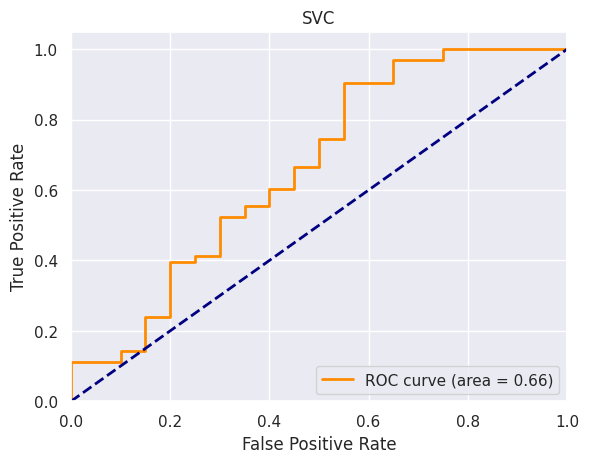

AUC: 0.66


In [94]:
y_pred_proba = svc_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

### Voting Classifier

In [95]:
model1_best_params = {'max_iter':335,
                       'C':96}

model2_best_params = {'n_estimators':930, 'max_depth':29, 'min_samples_split':13, 'min_samples_leaf':18,
                      'max_features':'sqrt'}

model3_best_params = {'n_estimators':135, 'learning_rate':0.01, 'max_depth':3, 'subsample':0.5,
                      'colsample_bytree':0.5, 'gamma':5}

model_4_best_params = {'n_estimators':254, 'learning_rate':0.04}


model_5_best_params = {'C':634}


model1 = LogisticRegression(**model1_best_params, penalty='l2', solver='lbfgs', random_state=42)

model2 = RandomForestClassifier(**model2_best_params, random_state=42)

model3 = XGBClassifier(**model3_best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')

model4 = AdaBoostClassifier(**model_4_best_params, random_state=42)

model5 = SVC(**model_5_best_params,kernel='rbf', gamma='scale', probability=True, random_state=42)


voting_clf = VotingClassifier(estimators=[('lr', model1), ('rfc', model2), ('xgb', model3),
                                          ('Ada', model4), ('SVC', model5)], voting='soft')


voting_clf.fit(X_train, y_train)

v_prediction = voting_clf.predict(X_test)

accuracy = accuracy_score(y_test, v_prediction)

print(f'Accuracy of the voting classifier: {accuracy*100:.2f}%')
print(classification_report(y_test, v_prediction))

Accuracy of the voting classifier: 84.34%
              precision    recall  f1-score   support

           0       0.89      0.40      0.55        20
           1       0.84      0.98      0.91        63

    accuracy                           0.84        83
   macro avg       0.86      0.69      0.73        83
weighted avg       0.85      0.84      0.82        83



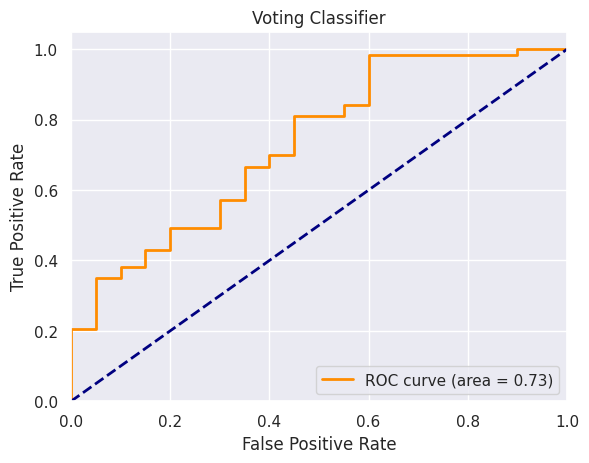

AUC: 0.73


In [96]:
voting_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, voting_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Classifier')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

### Stacking Classifier

In [97]:
model1 = make_pipeline_imb(MinMaxScaler(), SMOTE(random_state=42), LogisticRegression(max_iter=335, C=96, random_state=42))


model2 = make_pipeline_imb(SMOTE(random_state=42), RandomForestClassifier(n_estimators=930,
                                                                          max_depth=29,
                                                                          min_samples_split=13,
                                                                          min_samples_leaf=18,
                                                                          max_features='sqrt',
                                                                          random_state=42))

model3 = make_pipeline_imb(SMOTE(random_state=42), XGBClassifier(n_estimators=135,
                                                                 learning_rate=0.01,
                                                                 max_depth=3,
                                                                 subsample=0.5,
                                                                 colsample_bytree=0.5,
                                                                 gamma=5,
                                                                 random_state=42,
                                                                 use_label_encoder=False,
                                                                 eval_metric='logloss'))

model4 = make_pipeline_imb(SMOTE(random_state=42), AdaBoostClassifier(n_estimators=254, learning_rate=0.04,
                                                                      random_state=42))



stacking_clf = StackingClassifier(estimators=[('log', model1), ('rfc', model2), ('xgb', model3),('SVC', model4)],
                                  final_estimator=SVC(C=634, kernel='rbf', gamma='scale', probability=True,
                                                      random_state=42))

stacking_clf.fit(X_train, y_train)

stack_prediction = stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test, stack_prediction)

print(f'Accuracy of the Stacking Classifier: {accuracy*100:.2f}%')
print(classification_report(y_test, stack_prediction))

Accuracy of the Stacking Classifier: 84.34%
              precision    recall  f1-score   support

           0       0.89      0.40      0.55        20
           1       0.84      0.98      0.91        63

    accuracy                           0.84        83
   macro avg       0.86      0.69      0.73        83
weighted avg       0.85      0.84      0.82        83



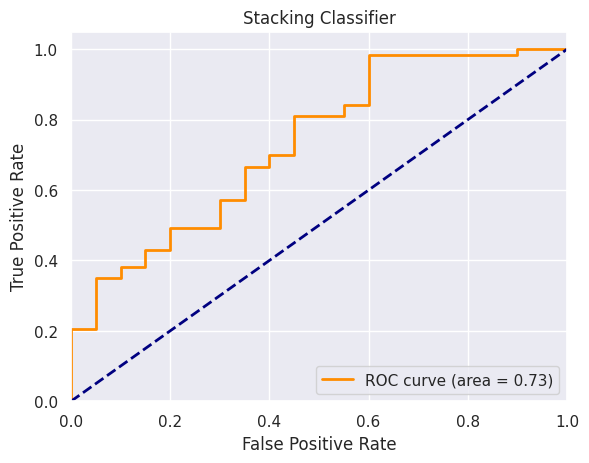

AUC: 0.73


In [98]:
stacking_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, voting_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Classifier')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')